In [13]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import signal, fftpack

In [14]:
sys.path.append(r'C:\Users\lesliec\code')

In [15]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset

In [16]:
%matplotlib notebook

Load Zap_Zip-log_exp to get metadata for experiments

In [17]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

#### Functions

In [18]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

### Define data paths and load EEGexp

In [19]:
test_subs = {
    '666196': r'P:\mouse666196\NOT FINISHED SORTING\pilot_aw_2023-03-15_12-29-06\experiment1\recording1',
    '669117': r'R:\mouse669117\pilot_aw_2023-03-29_11-09-15\experiment1\recording1',
    '666194': r'P:\mouse666194\pilot_aw_psi_2023-02-23_10-40-34\experiment1\recording1',
}

In [20]:
subjects_data = {}
for mouse, dataloc in test_subs.items():
    subjects_data[mouse] = {}
    print('{}'.format(mouse))
    subjects_data[mouse]['exp'] = EEGexp(dataloc, preprocess=False, make_stim_csv=False)

666196
Experiment type: electrical and sensory stimulation
669117
Experiment type: electrical stimulation
666194
Experiment type: electrical stimulation


## Plot EEG signals, whole recording

<IPython.core.display.Javascript object>


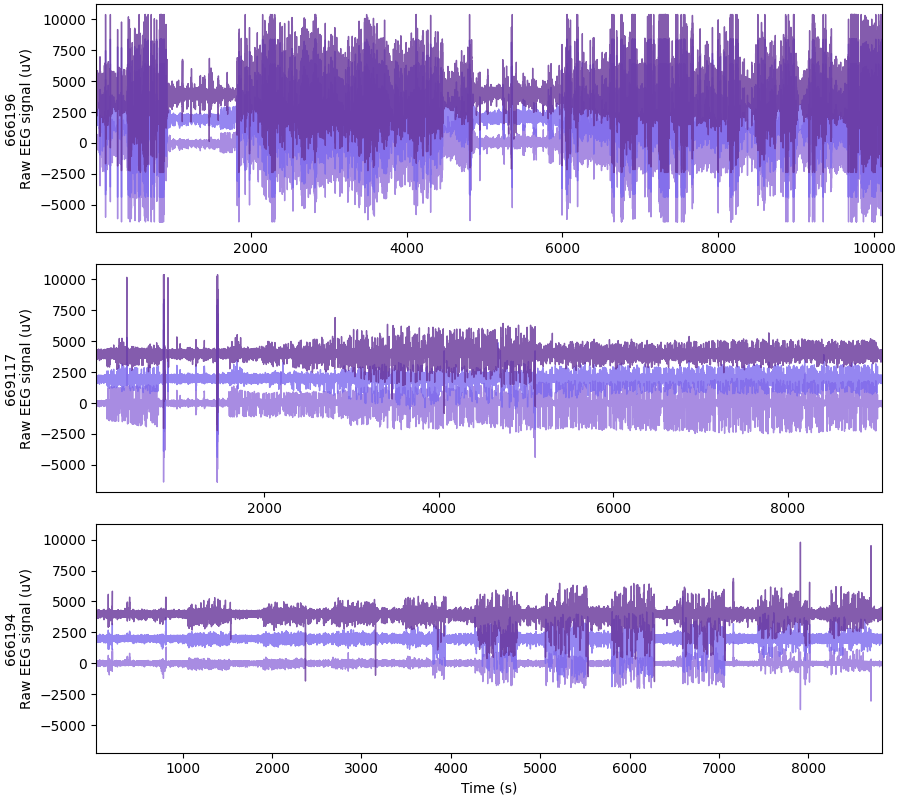

Text(0.5, 0, 'Time (s)')

In [12]:
plot_chs = [1, 10, 16]
offset = 2000 # 500
chcolors = ['mediumpurple','mediumslateblue','rebeccapurple','blueviolet','darkorchid','darkviolet']

fig, axs = plt.subplots(len(test_subs), figsize=(9, 8), constrained_layout=True, sharey=True)

for ax, (sub, datadict) in zip(axs, subjects_data.items()):
    eeg_data, eeg_ts = datadict['exp'].load_eegdata()
    for i, chi in enumerate(plot_chs):
        ax.plot(eeg_ts, eeg_data[:,chi] + i*offset, color=chcolors[i], linewidth=1, alpha=0.8, label=('Ch {:d}'.format(chi)))
    ax.set_xlim((eeg_ts[0], eeg_ts[-1]))
    ax.set_ylabel('{}\nRaw EEG signal (uV)'.format(sub))
    
ax.set_xlabel('Time (s)')

### Check spectra and RMS at the beginning and end of experiment

In [30]:
subcolors = {'666196': 'r', '669117': 'g', '666194': 'b'}
linestyles = ['solid', 'dashed']

<IPython.core.display.Javascript object>


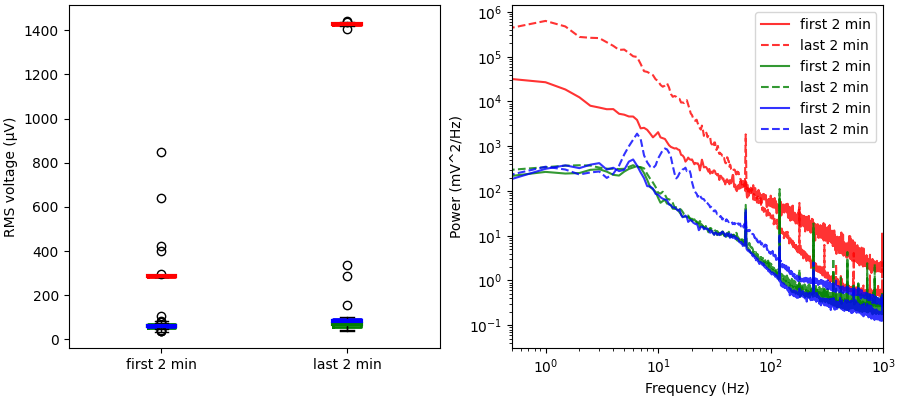

Text(0, 0.5, 'Power (mV^2/Hz)')

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(9,4), constrained_layout=True)
for sub, datadict in subjects_data.items():
    eeg_data, eeg_ts = datadict['exp'].load_eegdata()
    SR = subjects_data[sub]['exp'].ephys_params['EEG']['sample_rate']
    testsamps = int(120 * SR)

    EEG_test_data = {
        'first 2 min': eeg_data[:testsamps, :],
        'last 2 min': eeg_data[-testsamps:, :],
    }
    del eeg_data, eeg_ts
    for i, (timeper, datai) in enumerate(EEG_test_data.items()):
        RMS = np.sqrt(np.mean(datai**2, axis=0))
        axs[0].boxplot(
            RMS, positions=[i], showfliers=True,
            medianprops={'color': subcolors[sub], 'linewidth': 3}, boxprops={'color': subcolors[sub], 'linewidth': 2}
        )

        frex, Pxx = signal.welch(datai, SR, nperseg=2 * SR, axis=0)
        axs[1].loglog(
            frex, np.mean(Pxx, axis=1), color=subcolors[sub], linewidth=1.5, linestyle=linestyles[i], alpha=0.8, label=timeper
        )

axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(EEG_test_data.keys())
axs[0].set_ylabel('RMS voltage (\u03bcV)')

axs[1].set_xlim([0.5, 1000])
axs[1].legend()
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Power (mV^2/Hz)')

Test one subject

## Check LFP signals

<IPython.core.display.Javascript object>


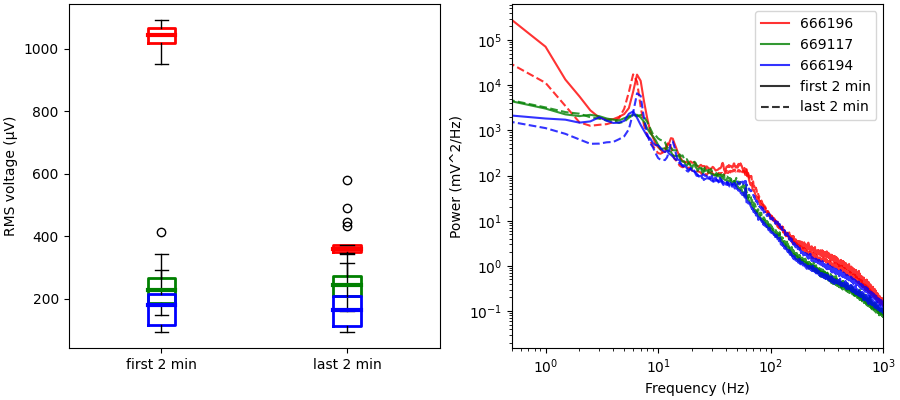

In [12]:
testprobe = 'probeB'
subcolors = {'666196': 'r', '669117': 'g', '666194': 'b'}
linestyles = ['solid', 'dashed']

fig, axs = plt.subplots(1, 2, figsize=(9,4), constrained_layout=True)
for sub in subjects_data.keys():
    SR = subjects_data[sub]['exp'].ephys_params[testprobe]['lfp_sample_rate']
    testsamps = int(120 * SR)

    ## Memmap raw LFP and reshape ##
    lfp_ts = np.load(subjects_data[sub]['exp'].ephys_params[testprobe]['lfp_timestamps'])
    lfp_mm = np.memmap(
        subjects_data[sub]['exp'].ephys_params[testprobe]['lfp_continuous'], dtype='int16',
        shape=(lfp_ts.size, subjects_data[sub]['exp'].ephys_params[testprobe]['num_chs']), mode='r'
    ) # Note this data is still in bits, not in microvolts #

    test_data = {
        'first 2 min': lfp_mm[:testsamps, np.arange(0, 351, 25)] * subjects_data[sub]['exp'].ephys_params[testprobe]['bit_volts'],
        'last 2 min': lfp_mm[-testsamps:, np.arange(0, 351, 25)] * subjects_data[sub]['exp'].ephys_params[testprobe]['bit_volts'],
    }
    del lfp_ts, lfp_mm
    
    for i, (timeper, datai) in enumerate(test_data.items()):
        RMS = np.sqrt(np.mean(datai**2, axis=0))
        axs[0].boxplot(
            RMS, positions=[i], showfliers=True,
            medianprops={'color': subcolors[sub], 'linewidth': 3}, boxprops={'color': subcolors[sub], 'linewidth': 2}
        )

        frex, Pxx = signal.welch(datai, SR, nperseg=2 * SR, axis=0)
        axs[1].loglog(
            frex, np.mean(Pxx, axis=1), color=subcolors[sub], linewidth=1.5, linestyle=linestyles[i], alpha=0.8, label=timeper
        )
        
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(test_data.keys())
axs[0].set_ylabel('RMS voltage (\u03bcV)')

axs[1].set_xlim([0.5, 1000])
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Power (mV^2/Hz)')

legh = []
for sub, subc in subcolors.items():
    legh.append(Line2D([],[], color=subc, linestyle='solid', alpha=0.8, label=sub))
legh.append(Line2D([],[], color='k', linestyle='solid', alpha=0.8, label='first 2 min'))
legh.append(Line2D([],[], color='k', linestyle='dashed', alpha=0.8, label='last 2 min'))
axs[1].legend(handles=legh)

Test one subject

## Check raw AP signals

<IPython.core.display.Javascript object>


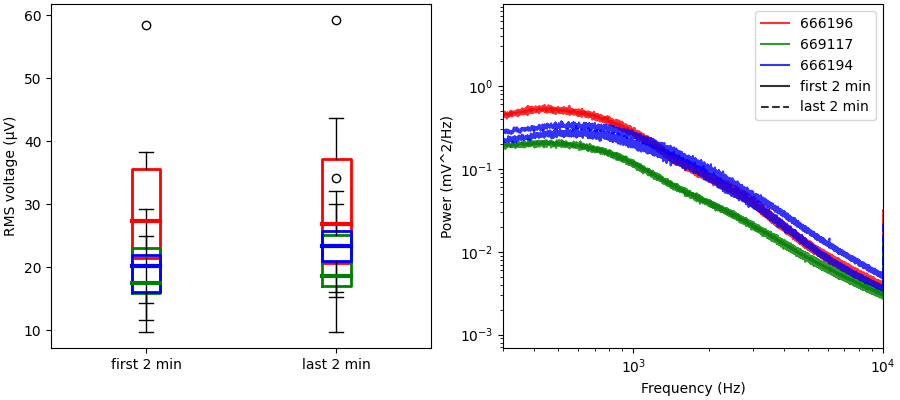

In [22]:
testprobe = 'probeB'
subcolors = {'666196': 'r', '669117': 'g', '666194': 'b'}
linestyles = ['solid', 'dashed']

fig, axs = plt.subplots(1, 2, figsize=(9,4), constrained_layout=True)
for sub in subjects_data.keys():
    SR = subjects_data[sub]['exp'].ephys_params[testprobe]['ap_sample_rate']
    testsamps = int(120 * SR)

    ## Memmap raw AP and reshape ##
    ap_ts = np.load(subjects_data[sub]['exp'].ephys_params[testprobe]['ap_timestamps'])
    ap_mm = np.memmap(
        subjects_data[sub]['exp'].ephys_params[testprobe]['ap_continuous'], dtype='int16',
        shape=(ap_ts.size, subjects_data[sub]['exp'].ephys_params[testprobe]['num_chs']), mode='r'
    ) # Note this data is still in bits, not in microvolts #

    test_data = {
        'first 2 min': ap_mm[:testsamps, np.arange(0, 351, 25)] * subjects_data[sub]['exp'].ephys_params[testprobe]['bit_volts'],
        'last 2 min': ap_mm[-testsamps:, np.arange(0, 351, 25)] * subjects_data[sub]['exp'].ephys_params[testprobe]['bit_volts'],
    }
    del ap_ts, ap_mm
    
    for i, (timeper, datai) in enumerate(test_data.items()):
        RMS = np.sqrt(np.mean(datai**2, axis=0))
        axs[0].boxplot(
            RMS, positions=[i], showfliers=True,
            medianprops={'color': subcolors[sub], 'linewidth': 3}, boxprops={'color': subcolors[sub], 'linewidth': 2}
        )

        frex, Pxx = signal.welch(datai, SR, nperseg=2 * SR, axis=0)
        axs[1].loglog(
            frex, np.mean(Pxx, axis=1), color=subcolors[sub], linewidth=1.5, linestyle=linestyles[i], alpha=0.8, label=timeper
        )
        
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(test_data.keys())
axs[0].set_ylabel('RMS voltage (\u03bcV)')

axs[1].set_xlim([300, 15000])
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Power (mV^2/Hz)')

legh = []
for sub, subc in subcolors.items():
    legh.append(Line2D([],[], color=subc, linestyle='solid', alpha=0.8, label=sub))
legh.append(Line2D([],[], color='k', linestyle='solid', alpha=0.8, label='first 2 min'))
legh.append(Line2D([],[], color='k', linestyle='dashed', alpha=0.8, label='last 2 min'))
axs[1].legend(handles=legh)

## Load number of units - prePHY

In [38]:
testprobe = 'probeC'

for sub in subjects_data.keys():
    cluster_group = pd.read_csv(subjects_data[sub]['exp'].ephys_params[testprobe]['cluster_group'], sep='\t')
    spike_times = np.load(subjects_data[sub]['exp'].ephys_params[testprobe]['spike_times'])
    spike_clusters = np.load(subjects_data[sub]['exp'].ephys_params[testprobe]['spike_clusters'])
    print('{}: {:d} good / {:d} total units'.format(sub, np.sum(cluster_group['group'] == 'good'), len(cluster_group)))
    print(' {:d} cluster ids, {:d} total spikes'.format(len(np.unique(spike_clusters)), len(spike_times)))

666196: 679 good / 845 total units
 845 cluster ids, 46022849 total spikes
669117: 696 good / 809 total units
 809 cluster ids, 39211462 total spikes
666194: 597 good / 769 total units
 769 cluster ids, 30128470 total spikes


In [ ]:
sub = '666196'

spike_times = np.load(subjects_data[sub]['exp'].ephys_params[testprobe]['spike_times'])
spike_clusters = np.load(subjects_data[sub]['exp'].ephys_params[testprobe]['spike_clusters'])